<a href="https://colab.research.google.com/github/UrielV1/cifar10-classification/blob/main/cifar_10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, \
Dropout, GlobalMaxPooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model

### Importing the data

In [ ]:
cifar10 = tf.keras.datasets.cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


### Feature engineering and basic exploration

In [ ]:
x_test = x_test/255.0
x_train = x_train/255.0

In [ ]:
y_test = y_test.flatten()
y_train = y_train.flatten()
N = len(set(y_train))

In [ ]:
print("The image shape is:", x_test.shape[1:])
print("The number of classes is:", N)
print(f"There are {x_train.shape[0]} train images and {x_test.shape[0]} test images")

The image shape is: (32, 32, 3)
The number of classes is: 10
There are 50000 train images and 10000 test images


- The train set includes 10 classes with 5000 samples each
- As we can see it is perfectly balanced 

In [ ]:
import matplotlib
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13)

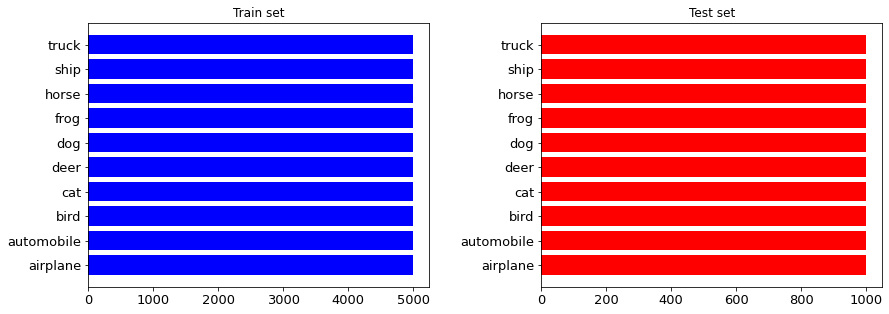

In [ ]:
f = plt.figure(figsize=(13,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.barh(np.unique(y_train, return_counts=True)[0], np.unique(y_train, return_counts=True)[1], color=['blue'], 
        tick_label=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
ax1.title.set_text('Train set')

ax2.barh(np.unique(y_test, return_counts=True)[0], np.unique(y_test, return_counts=True)[1], color=['red'], 
        tick_label=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
ax2.title.set_text('Test set')

f.tight_layout(pad=3.0)

- The train set includes 10 classes with 5000 samples each
- The test set includes 10 classes with 1000 samples each
- As we can see both are perfectly balanced 

# Building the Models

## 1st Model

In [ ]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=x_train[0].shape),
  Conv2D(32, (3, 3), strides=2, activation='relu'),
  Conv2D(64, (3, 3), strides=2, activation='relu'),
  Conv2D(128, (3, 3), strides=2, activation='relu'),
  Flatten(),
  Dropout(0.5),
  Dense(1024, activation='relu'),
  Dropout(0.2),
  Dense(N, activation='softmax')
])

In [ ]:
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [103]:
m1 = model1.fit(x_train, y_train, validation_split=0.1, epochs=20)

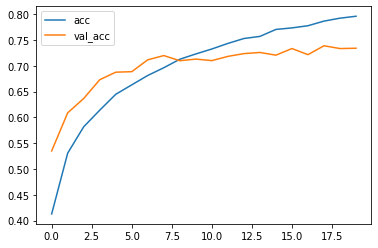

In [ ]:
plt.plot(m1.history['accuracy'], label='acc')
plt.plot(m1.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

Test performance

In [ ]:
model1.evaluate(x=x_test, y=y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.8306 - accuracy: 0.7079


[0.830616295337677, 0.7078999876976013]

Observations
- Dropout layers in between Conv2D didn't help
- It seems like after ~20 epochs the validation accuracy stablizes at 73%
- The test accuracy is nearly 71%

## 2nd Model - Improved version
- After each Convolution layer a Batch Normalization layer was added
- In this way we make sure the data are normalized at each step
- Max Pooling layer was added alternately after Convolution and Batch Normalization layers
- Using the Max Pooling layers enables the model to observe bigger segments within the images  

In [ ]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=x_train[0].shape),
  Conv2D(32, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  Conv2D(32, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),
  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),
  Conv2D(128, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  Conv2D(128, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),
  Flatten(),
  Dropout(0.4),
  Dense(1024, activation='relu'),
  Dropout(0.4),
  Dense(N, activation='softmax')
])

In [ ]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [104]:
m2 = model2.fit(x_train, y_train, validation_split=0.2, epochs=50)

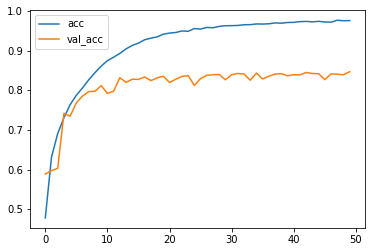

In [ ]:
plt.plot(m2.history['accuracy'], label='acc')
plt.plot(m2.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
model2.evaluate(x=x_test, y=y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.7049 - accuracy: 0.8414


[0.7049285173416138, 0.8414000272750854]

Observations\Comments
- The validation score is fluctuating around 84%
- The test score was also 84%
- There is a very big overfit as the train score is nearly 98%
- Number of epochs and dropout layers were slightly tuned

## 3rd Model - Using Data Augmentation

In [ ]:
from sklearn.model_selection import train_test_split

Recreating x_train and y_train - using x_val, y_val notation

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.05, height_shift_range=0.05, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

In [ ]:
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=x_train[0].shape),
  Conv2D(32, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  Conv2D(32, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),
  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),
  Conv2D(128, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  Conv2D(128, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),
  Flatten(),
  Dropout(0.4),
  Dense(1024, activation='relu'),
  Dropout(0.4),
  Dense(N, activation='softmax')
])

In [ ]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [105]:
m3 = model3.fit_generator(train_generator, validation_data=(x_val, y_val), steps_per_epoch=steps_per_epoch, epochs=50)

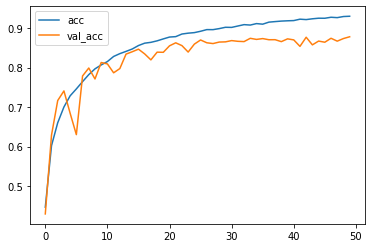

In [ ]:
plt.plot(m3.history['accuracy'], label='acc')
plt.plot(m3.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
model3.evaluate(x=x_test, y=y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4162 - accuracy: 0.8708


[0.4161597788333893, 0.8708000183105469]

Observations\Comments
- The validation score is fluctuating around 87%
- The test score was also 87%
- The overfit problem was reduced as the train score is 93%
- Augmentation hyperparameters were slightly tuned - e.g width and height shift

## Summary
- In this work three different CNN models were tested
- The first model was pretty basic, including 3 convolutional layers. The test score was 71%
- The second model included 6 convolutional layers, as well as max pooling and batch normalization layers. The test score was 84%.
- The third model was in fact the same as the second, including data augmentation. It yielded the best reslut with test score of 87%
- For each of the models the hyperparameters were slightly tuned to optimize the results

## Conclusions
- As the complexity of the model increases it may yield better results, but the overfitting problem increases as well
- There are some common architectures that are able to solve simple and generic problems
- As expexted, the augmented data improved the results and reduced the overfitting
- In order to optimize the results the different hyperparameters should be tuned carefully